In [1]:
import os
import pickle
import copy
import dateutil.parser
from tqdm import tqdm
from typing import Tuple, List, Dict
from collections import defaultdict

import numpy as np
import pandas as pd
import scipy
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt


DATA_PATH = "data"
PATH_PLAYERS = os.path.join(DATA_PATH, "players.pkl")
PATH_RESULTS = os.path.join(DATA_PATH, "results.pkl")
PATH_TOURNAMENTS = os.path.join(DATA_PATH, "tournaments.pkl")

# Раздел 1. Предобработка данных   

Прочитаем и проанализируем данные, отберем турниры, в которых есть данные о составах команд и повопросных результатах. Для унификации предлагается:  
- взять в тренировочный набор турниры с dateStart из 2019 года;
- в тестовый — турниры с dateStart из 2020 года.


In [2]:
TRAIN_YEAR = 2019
TEST_YEAR = 2020

players = pickle.load(open(PATH_PLAYERS, 'rb'))
results = pickle.load(open(PATH_RESULTS, 'rb'))
tournaments = pickle.load(open(PATH_TOURNAMENTS, 'rb'))

In [3]:
all_mask = []
n_answers = defaultdict(set)
for id in results:
    for result in results[id]:
        if "mask" in result and result["mask"] is not None:
            all_mask.append(set(result["mask"]))
            n_answers[id].add(len(result["mask"]))

print("Возможные маски повопросных результатов:")
print('\n'.join(set(map(str, all_mask))))

print("\nПримеры ID соревнований c разным числом вопросов:")
different_answers = [{id: value} for id, value in n_answers.items() if len(value) > 1]
print('\n'.join(map(str, different_answers[:4])))

Возможные маски повопросных результатов:
{'X', '1', '0'}
{'X', '0'}
{'1', '?', '0'}
{'0'}
{'1', '0'}
{'X', '1', '?', '0'}
{'X', '1'}
{'1'}

Примеры ID соревнований c разным числом вопросов:
{1531: {36, 12}}
{1534: {48, 36}}
{1780: {48, 60}}
{1817: {48, 36}}


Есть соревнования, в которых команды отвечали на разное число вопросов. Также в масках повопросных результатов есть ответы вида "?" и "Х", заменим их на 0. В датасеты будем брать соревнования, хотя бы с одним описанием членов команды и с одинаковым количеством вопросов для каждой из команд.

In [4]:
train_tournaments, test_tournaments = [], []
for id_tournament, tournament in tournaments.items():
    tournament_result = results[id_tournament]
    year = dateutil.parser.parse(tournament["dateStart"]).year

    mask = False
    team_members = False
    questions_in_tournament = set()

    for team_result in tournament_result:
        if "teamMembers" in team_result and len(team_result['teamMembers']) > 0:
            team_members = True

        if "mask" in team_result and team_result["mask"] is not None:
            mask = True
            questions_in_tournament.add(len(team_result['mask']))

    if mask and team_members and len(questions_in_tournament) == 1:
        if year == TRAIN_YEAR:
            train_tournaments.append(id_tournament)
        if year == TEST_YEAR:
            test_tournaments.append(id_tournament)


In [5]:
print(f"Размер обучающей выборки: {len(train_tournaments)}")
print(f"Размер тестовой выборки: {len(test_tournaments)}")

Размер обучающей выборки: 663
Размер тестовой выборки: 169


In [6]:
def get_data(id_tournaments: List) -> Tuple[List, List, List, Dict]:
    data = []
    id_players = set()
    id_questions = []

    for id_tournament in tqdm(id_tournaments):
        tournament_result = results[id_tournament]

        tournament = {}
        tournament['id_tournament'] = id_tournament
        tournament["teams"] = []

        for team_result in tournament_result:
            if "mask" in team_result and team_result["mask"] is not None \
                    and "teamMembers" in team_result and len(team_result['teamMembers']) > 0:
                mask = team_result["mask"].replace("?", "0").replace("X", "0")
                tournament["n_questions"] = len(mask)

                team = {}
                team["id_team"] = team_result["team"]["id"]
                team["mask"] = list(map(int, mask))
                team['position'] = team_result['position']

                team["id_players"] = []
                for player in team_result["teamMembers"]:
                    team["id_players"].append(player["player"]["id"])
                    id_players.add(player["player"]["id"])

                team["n_players"] = len(team["id_players"])
                tournament["teams"].append(team)

        for id in range(len(mask)):
            id_questions.append(str(id_tournament) + '_' + str(id))

        data.append(tournament)

    id_players = sorted(list(id_players))
    player2id = {player: id for id, player in enumerate(id_players)}

    return data, id_players, id_questions, player2id


In [7]:
train, train_id_players, train_id_questions, train_player2id  = get_data(train_tournaments)
test, test_id_players, test_id_questions, test_player2id  = get_data(test_tournaments)

100%|██████████| 169/169 [00:00<00:00, 1880.68it/s]


# Раздел 2. Baseline-модель 

Построим baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. 

- повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;

- в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;

- для baseline-модели можно забыть о командах и считать, что повопросные
результаты команды просто относятся к каждому из её игроков.

In [8]:
def get_X_y(
        data: List,
        id_players: List,
        id_questions: List,
        player2id: Dict
        ) -> Tuple[scipy.sparse.spmatrix, np.array]:

    shift_players = len(id_players)
    X_columns = shift_players + len(id_questions)
    X_rows = 0
    for tournament in data:
        for team in tournament["teams"]:
            X_rows += team["n_players"] * tournament["n_questions"]

    X = scipy.sparse.lil_matrix((X_rows, X_columns), dtype=np.int8)
    y = np.zeros(X_rows)

    row = 0
    shift_questions = shift_players
    for tournament in tqdm(data):
        for team in tournament["teams"]:
            for id_question in range(tournament["n_questions"]):
                label = team["mask"][id_question]
                shift_question = shift_questions + id_question
                for id_player in team['id_players']:
                    id_player = player2id[id_player]
                    X[row, id_player] = 1
                    X[row, shift_question] = 1
                    y[row] = label
                    row += 1

        shift_questions += tournament["n_questions"]

    return X, y


In [9]:
X_train, y_train = get_X_y(
    train,
    train_id_players,
    train_id_questions,
    train_player2id
)

100%|██████████| 663/663 [01:03<00:00, 10.47it/s]


In [10]:
log_reg = LogisticRegression(solver='saga')
log_reg.fit(X_train, y_train);

strength = log_reg.coef_[0][:len(train_id_players)]
complexity = log_reg.coef_[0][len(train_id_players):]

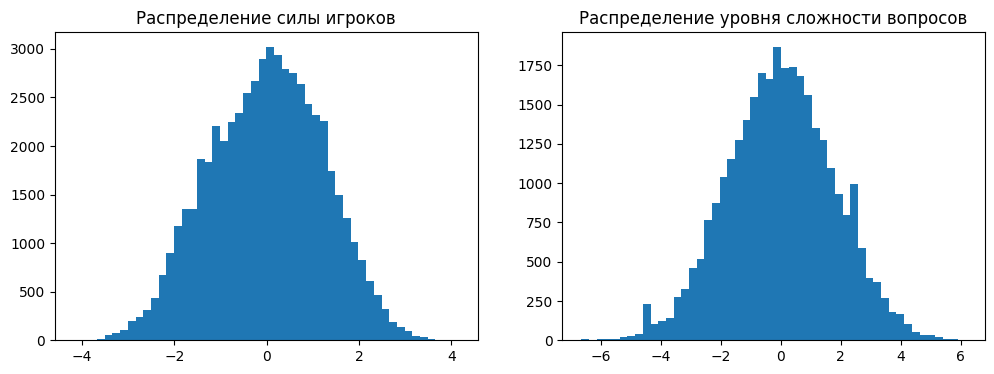

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(strength, bins=50)
ax[1].hist(complexity, bins=50)

ax[0].set_title("Распределение силы игроков")
ax[1].set_title("Распределение уровня сложности вопросов")
plt.show()

Рассчитаем для каждого игрока из тренировочной выборки его опыт в чгк, учтем сложность вопросов и дополнительно получим сложность турниров. Также отнормируем значения силы игроков, все это понадобится для следующего раздела.

In [12]:
def get_players_experience(
        data: List,
        df_tournaments: pd.DataFrame,
        player2id: Dict
):

    players_experience = {player: [] for player in player2id.keys()}

    for tournament in data:
        id_tournament = tournament["id_tournament"]
        tournament_complexity = df_tournaments["complexity"][id_tournament]
        team_positions = []

        for team in tournament["teams"]:
            team_positions.append(team["position"])

        position_max = max(team_positions)

        for team in tournament["teams"]:
            for id_player in team["id_players"]:
                players_experience[id_player].append(
                    (1 - (team["position"] / position_max)) * tournament_complexity
                )

    for key in players_experience.keys():
        players_experience[key] = np.mean(players_experience[key])

    df_players_experience = pd.DataFrame.from_dict(
        players_experience,
        orient="index",
        columns=["experience"]
    )

    return df_players_experience


In [13]:
def get_results_from_model(
        model: LogisticRegression,
        data: List,
        tournaments: Dict,
        players: Dict,
        id_players: List,
        id_tournaments: List,
        id_questions: List,
        player2id: Dict
):

    df_players = pd.DataFrame(players.values()).set_index("id")
    df_tournaments = pd.DataFrame.from_dict(tournaments, orient='index').set_index("id")
    df_tournaments = df_tournaments.iloc[df_tournaments.index.isin(id_tournaments)]

    df_questions = pd.DataFrame(
        {
            'id_question': id_questions,
            'id_tournament': list(map(lambda x: tuple(map(int, x.split("_")))[0], id_questions)),
            'complexity': model.coef_[0][len(id_players):]
        }
    ).set_index('id_question')

    df_players_final = pd.DataFrame(
        {
            'id_player': id_players,
            'strength': model.coef_[0][:len(id_players)]
        }
    ).set_index('id_player')

    df_tournaments_final = df_questions \
        .groupby("id_tournament") \
        .mean("comlexity") \
        .join(df_tournaments[["name"]]) \
        .sort_values("complexity")

    df_tournaments_final["complexity"] = (- 1) * df_tournaments_final["complexity"]

    complexity_min = df_tournaments_final["complexity"].min()
    df_tournaments_final["complexity"] += np.abs(complexity_min)
    complexity_max = df_tournaments_final["complexity"].max()
    df_tournaments_final["complexity"] = df_tournaments_final["complexity"] / complexity_max

    df_players_experience = get_players_experience(
        data,
        df_tournaments_final,
        player2id
    )

    df_players_experience = df_players_final \
        .join(df_players) \
        .sort_values('strength', ascending=False) \
        .join(df_players_experience)

    strength_min = df_players_experience["strength"].min()
    df_players_experience["strength"] += np.abs(strength_min)
    strength_max = df_players_experience["strength"].max()
    df_players_experience["strength"] = df_players_experience["strength"] / strength_max

    return df_players_experience, df_tournaments_final


In [14]:
df_players_experience, df_tournaments_final = get_results_from_model(
        log_reg,
        train,
        tournaments,
        players,
        train_id_players,
        train_tournaments,
        train_id_questions,
        train_player2id
)

In [15]:
df_players_experience

,strength,name,patronymic,surname,experience
id_player,,,,,
27403,1.000000,Максим,Михайлович,Руссо,0.421950
4270,0.984772,Александра,Владимировна,Брутер,0.406532
28751,0.979335,Иван,Николаевич,Семушин,0.413637
27822,0.968776,Михаил,Владимирович,Савченков,0.405316
30270,0.959136,Сергей,Леонидович,Спешков,0.410848
...,...,...,...,...,...
209400,0.048964,Илья,Владиславович,Шапуров,0.001083
209401,0.048964,Михаил,Максимович,Казарин,0.001083
203842,0.045484,Вероника,Андреевна,Балакина,0.000785


In [16]:
df_tournaments_final

,complexity,name
id_tournament,,
6149,1.000000,Чемпионат Санкт-Петербурга. Первая лига
5928,0.687428,Угрюмый Ёрш
5684,0.668402,Синхрон высшей лиги Москвы
5159,0.654179,Первенство правого полушария
6101,0.641656,Воображаемый музей
...,...,...
5012,0.046990,Школьный Синхрон-lite. Выпуск 2.5
5698,0.036158,(а)Синхрон-lite. Лига старта. Эпизод VII
5702,0.033841,(а)Синхрон-lite. Лига старта. Эпизод IX


# Раздел 3. Предсказание результатов нового турнира

Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли
смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:

- предложим способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;

- в качестве метрики качества на тестовом наборе будем считать ранговые корреляции Спирмена и Кендалла между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров.

Основная идея состоит в том, чтобы учесть силу игрока, вероятность его ответа на вопрос средней сложности, а также опыт игры в предыдущих турнирах умноженный на  коэффициент. После получаем усредненную характеристику для команды в целом:  

$$\displaystyle S = \frac{\sum_{i=1}^{N}{\frac{(p_{i} + s_{i})}{2} + 0.2 \cdot e_{i}}}{N}$$

где:<br>
* $S$ — сила команды,
* $p_{i}$ — вероятность ответа $i$ игрока на вопрос средней сложности,
* $s_{i}$ — сила $i$ игрока,
* $e_{i}$ — опыт $i$ игрока в предыдущих турнирах,
* $N$ — количество игроков в команде.

In [17]:
def get_test_result(
    model: LogisticRegression,
    train_players_experience: pd.DataFrame,
    train_id_players: List,
    train_id_questions: List,
    train_player2id: Dict,
    test: List,
    ):

    middle_question = np.abs(model.coef_[0][len(train_id_players):]).min()
    id_middle_question = np.where(np.abs(model.coef_[0][len(train_id_players):]) == middle_question)
    id_middle = id_middle_question[0][0]

    shift_players = len(train_id_players)
    X_columns = shift_players + len(train_id_questions)
    id_question = id_middle + shift_players

    test_results = {}
    for tournament in test:

        tournament_results = {}
        for team in tournament["teams"]:
            true_position = team["position"]
            team_players = []

            for player in team["id_players"]:
                if player in train_id_players:
                    team_players.append(player)

            players_strength = []
            players_experience = []
                    
            if len(team_players) > 0:
                X_rows = len(team_players)
                X_test = scipy.sparse.lil_matrix((X_rows, X_columns), dtype=np.int8)

                for row, player in enumerate(team_players):
                    id_player = train_player2id[player]
                    X_test[row, id_player] = 1
                    X_test[row, id_question] = 1

                    players_strength.append(train_players_experience["strength"][player])
                    players_experience.append(train_players_experience["experience"][player])

                predicted = model.predict_proba(X_test)[:, 1]
                predicted = np.full(predicted.shape, 1 - np.prod(1 - predicted))

                overall_result = np.array(list(map(
                    lambda x, y, z: ((x + y) / 2) + 0.2 * z, 
                    predicted, 
                    players_strength, 
                    players_experience
                    ))).mean()

                team_raitings = {
                    "prediction": overall_result,
                    "true_position": true_position
                    }

                tournament_results[team["id_team"]] = team_raitings

        test_results[tournament["id_tournament"]] = tournament_results

    return test_results


In [18]:
test_results = get_test_result(
    log_reg,
    df_players_experience,
    train_id_players,
    train_id_questions,
    train_player2id,
    test
    )

In [19]:
def get_score(results: Dict):
    spearman_correlations = []
    kendall_correlations = []

    for tournament in results.values():
        true_position = []
        prediction = []
        for team in tournament.values():
            true_position.append(team["true_position"])
            prediction.append(team["prediction"])

        spearman_correlations.append(scipy.stats.spearmanr(prediction, true_position).correlation)
        kendall_correlations.append(scipy.stats.kendalltau(prediction, true_position).correlation)

    spearman_score = abs(np.array(list(filter(lambda v: v == v, spearman_correlations))).mean())
    kendall_score = abs(np.array(list(filter(lambda v: v == v, kendall_correlations))).mean())
    
    return spearman_score, kendall_score


In [20]:
spearman_score, kendall_score = get_score(test_results)

print(f"Корреляция Спирмена: {round(spearman_score, 5)}")
print(f"Корреляция Кендалла: {round(kendall_score, 5)}")

Корреляция Спирмена: 0.81037
Корреляция Кендалла: 0.65182


# Раздел 4. EM-алгоритм

- предложим способ учитывать то, что на вопрос отвечают сразу несколько игроков, скорее всего, понадобятся скрытые переменные, теперь переменные "игрок X ответил на вопрос Y" при условии данных должны стать зависимыми для игроков одной и той же команды;  

- разработаем EM-схему для обучения этой модели;

- обучим несколько итераций, убедимся, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберем лучшую модель, используя целевые метрики.

Ранее мы предполагали, что результат ответа на вопрос относится ко всем игрокам команды. Но правильный ответ могут знать не все игроки команды. Будем считать, что команда дает правильный ответ, если хотя бы один из игроков команды знает правильный ответ, а если никто из игроков не знает правильного ответа, то команда не дает правильного ответа, при этом игроки отвечают на вопрос независимо.

Пусть 
- $z_{ij} = 1$ — $i$ игрок знает правильный ответ на $j$ вопрос,
- $\theta_n$ — параметры модели с предыдущей итерации ЕМ алгоритма, 
- $y$ — результат ответа на вопрос.  

Вероятность правильного ответа команды: $p(y|\theta_n)=1-\prod_i(1-p(z_{ij}|\theta_n)$  
Тогда получим: $p(z_{ij}|y,\theta_n)=\begin{cases}\frac{p(z_{ij}|\theta_n)}{1-\prod_i(1-p(z_{ij}|\theta_n)}\\0\end{cases}$  

Е-шаг: $Q(\theta, \theta_n)=\mathbb{E}[\log p(y, z|\theta)|y,\theta_n] = \sum p(z|y,\theta_n) \log p(y, z|\theta) + (1 - p(z|y, \theta_n)) \log(1 - p(y, z|\theta))$  
где $p(z|y, \theta_n)$ - вероятности, а не известные бинарные ответы.

М-шаг: Обучение логистической регрессии, при этом предварительно создаем
- две идентичные копии строк матрицы признаков,
- два значения для таргета 0 и 1,
- два значения sample_weight равные $p(z_{ij}|y, \theta_n)$ и $1 - p(z_{ij}|y, \theta_n)$.

In [21]:
em_model = copy.deepcopy(log_reg)
em_X_train = scipy.sparse.vstack([X_train, X_train], dtype=np.int8)
em_y_train = np.concatenate((np.full(X_train.shape[0], 1), np.full(X_train.shape[0], 0)))

In [22]:
def E_step(em_model, em_X_train, em_y_train, train):
    sample_weight = np.zeros(em_X_train.shape[0])
    predicted = em_model.predict_proba(em_X_train)

    X_rows = int(em_X_train.shape[0] / 2)
    row = 0

    for tournament in train:
        for team in tournament["teams"]:
            n_players = team["n_players"]
            for id_question in range(tournament["n_questions"]):
                true_y = team["mask"][id_question]
                if true_y == 0:
                    sample_weight[row: row + n_players] = 0
                    sample_weight[X_rows + row: X_rows + row + n_players] = 1
                else:
                    p = predicted[row: row + n_players, 1]
                    p = p / (1 - (1 - p).prod())
                    p = np.clip(p, 0, 1)

                    sample_weight[row: row + n_players] = list(p)
                    sample_weight[X_rows + row: X_rows + row + n_players] = list(1 - p)

                row += n_players

    return sample_weight


def M_step(sample_weight, em_X_train, em_y_train):
    em_model = LogisticRegression(solver="saga")
    em_model.fit(em_X_train, em_y_train, sample_weight=sample_weight)
    return em_model


In [23]:
em_epochs = 5
spearman_history = []
kendall_history = []

for epoch in tqdm(range(em_epochs)):
    sample_weight = E_step(em_model, em_X_train, em_y_train, train)
    em_model = M_step(sample_weight, em_X_train, em_y_train)
    
    test_results = get_test_result(
        em_model,
        df_players_experience,
        train_id_players,
        train_id_questions,
        train_player2id,
        test
        )
    spearman_score, kendall_score = get_score(test_results)
    
    print(f"Эпоха {epoch + 1}")
    print(f"Корреляция Спирмена: {round(spearman_score, 5)}")
    print(f"Корреляция Кендалла: {round(kendall_score, 5)}\n")

    if (
        len(spearman_history) != 0 
        and len(kendall_history) != 0
        and (spearman_history[-1] > spearman_score or kendall_history[-1] > kendall_score)
        ):
        break

    spearman_history.append(spearman_score)
    kendall_history.append(kendall_score)


 20%|██        | 1/5 [07:46<31:07, 466.80s/it]

Эпоха 1
Корреляция Спирмена: 0.81347
Корреляция Кендалла: 0.6556



 40%|████      | 2/5 [15:28<23:11, 463.81s/it]

Эпоха 2
Корреляция Спирмена: 0.81474
Корреляция Кендалла: 0.65625



 60%|██████    | 3/5 [23:30<15:44, 472.15s/it]

Эпоха 3
Корреляция Спирмена: 0.81504
Корреляция Кендалла: 0.65712



 80%|████████  | 4/5 [31:18<07:50, 470.58s/it]

Эпоха 4
Корреляция Спирмена: 0.81646
Корреляция Кендалла: 0.6593



100%|██████████| 5/5 [39:39<00:00, 475.98s/it]

Эпоха 5
Корреляция Спирмена: 0.818
Корреляция Кендалла: 0.66142



# Раздел 5. "Рейтинг-лист" турниров

Построим "рейтинг-лист" турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)?

In [37]:
df_tournaments = pd.DataFrame.from_dict(tournaments, orient='index').set_index("id")
df_tournaments = df_tournaments.iloc[df_tournaments.index.isin(train_tournaments)] 

df_questions = pd.DataFrame(
        {
            'id_question': train_id_questions,
            'id_tournament': list(map(lambda x: tuple(map(int, x.split("_")))[0], train_id_questions)),
            'complexity': em_model.coef_[0][len(train_id_players):]
        }
    ).set_index('id_question')

questions_with_tournaments = df_questions.join(
    df_tournaments[["name"]], 
    how="right", 
    on="id_tournament").sort_values("complexity")

In [38]:
questions_with_tournaments.head(10)

,id_tournament,complexity,name
id_question,,,
5757_30,5757,-4.998409,Открытый Кубок России
5757_34,5757,-4.998409,Открытый Кубок России
5757_14,5757,-4.998409,Открытый Кубок России
5819_25,5819,-4.846226,ОВСЧ. 2 этап
5718_5,5718,-4.791381,Топ-1000
5718_18,5718,-4.791380,Топ-1000
5756_33,5756,-4.775103,Жизнь и время Михаэля К.
5756_18,5756,-4.775103,Жизнь и время Михаэля К.
5756_11,5756,-4.775103,Жизнь и время Михаэля К.


In [43]:
questions_with_tournaments.tail(10)

,id_tournament,complexity,name
id_question,,,
5822_15,5822,5.117686,ОВСЧ. 5 этап
5128_22,5128,5.207428,Лига Сибири. IV тур.
5012_4,5012,5.218552,Школьный Синхрон-lite. Выпуск 2.5
5313_1,5313,5.305365,(а)Синхрон-lite. Лига старта. Эпизод VI
5841_0,5841,5.398594,Серия Гран-при. 2 этап. Гран-при Казахстана
5013_4,5013,5.433872,(а)Синхрон-lite. Лига старта. Эпизод V
6008_1,6008,5.477743,Малый кубок Физтеха
5418_0,5418,5.609672,Зеркало Альпийского Эдельвейса
5644_23,5644,5.632257,Школьный чемпионат России


In [39]:
_, df_tournaments_final = get_results_from_model(
        em_model,
        train,
        tournaments,
        players,
        train_id_players,
        train_tournaments,
        train_id_questions,
        train_player2id
)

In [41]:
df_tournaments_final.head(10)

,complexity,name
id_tournament,,
6149,1.000000,Чемпионат Санкт-Петербурга. Первая лига
5928,0.807833,Угрюмый Ёрш
5159,0.779023,Первенство правого полушария
5684,0.771464,Синхрон высшей лиги Москвы
5025,0.742827,Кубок городов
5465,0.731965,Чемпионат России
6101,0.730529,Воображаемый музей
5942,0.710378,Чемпионат Мира. Этап 2. Группа В
5587,0.705631,Записки охотника


In [42]:
df_tournaments_final.tail(10)

,complexity,name
id_tournament,,
5457,0.096756,Студенческий чемпионат Калининградской области
5011,0.091256,(а)Синхрон-lite. Лига старта. Эпизод IV
6003,0.080795,Второй тематический турнир имени Джоуи Триббиани
5704,0.076754,(а)Синхрон-lite. Лига старта. Эпизод X
5313,0.068654,(а)Синхрон-lite. Лига старта. Эпизод VI
5698,0.054318,(а)Синхрон-lite. Лига старта. Эпизод VII
5009,0.038451,(а)Синхрон-lite. Лига старта. Эпизод III
5702,0.031372,(а)Синхрон-lite. Лига старта. Эпизод IX
5438,0.028154,Синхрон Лиги Разума


Сформированный "рейтинг-лист" турниров по сложности вопросов соответствует ожиданиям и интуиции.